In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import scipy
import cobra

# Bacillus

In [3]:
exometabolites_folder = Path("../../data/b_licheniformis/")
organism = 'b_licheniformis'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [4]:
gDW_per_OD = 0.32

In [5]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, organism)

In [6]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,1.700,0.000000
1,1.745,0.007071
2,1.905,0.063640
3,2.080,0.042426
4,3.095,0.120208
5,4.235,0.007071
6,6.940,0.197990
7,9.735,0.035355
8,15.110,1.230366


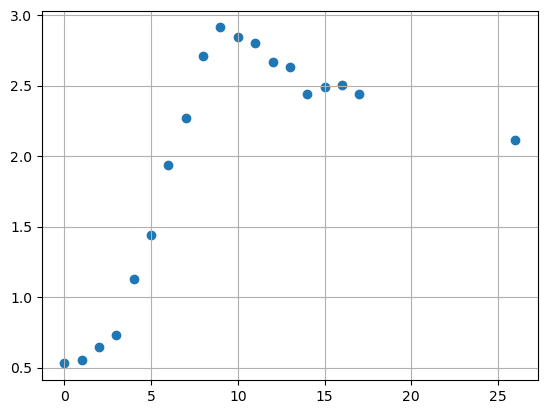

In [7]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

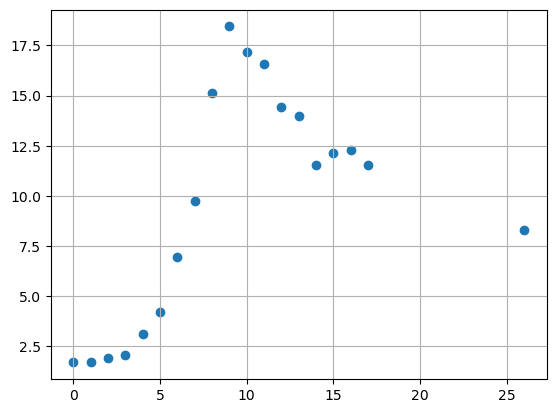

In [18]:
plt.scatter(df_OD.index, df_OD['OD mean'])
plt.grid()

# Estimate max glucose uptake rate
Answer = 5.3 mmol/gDW/h

In [8]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
# df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [9]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [10]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

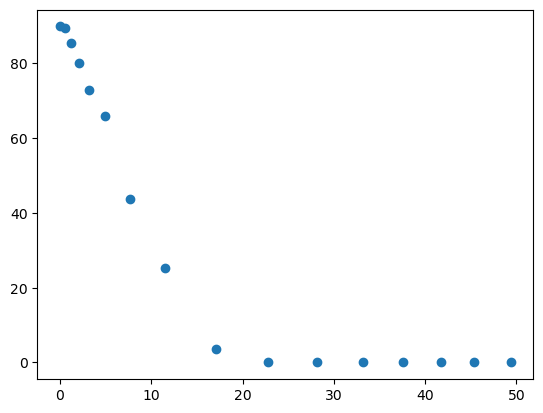

In [11]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [12]:
df_OD.loc[1:9, 'Cum OD gDW']

Time
1     0.000000
2     0.584000
3     1.220800
4     2.026800
5     3.214933
6     4.942533
7     7.666133
8    11.514533
9    17.118400
Name: Cum OD gDW, dtype: float64

In [13]:
np.polyfit(df_OD.loc[1:9, 'Cum OD gDW'], df_glucose.loc[1:9, 'Glucose mM'], 1)

array([-5.32392386, 90.3905335 ])

## Mapping

In [14]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Bacillus metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

## Simpson integration

In [15]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 1.745 0.5512
2 1.905 1.1290666666666664
3 2.08 1.7693333333333334
4 3.095 2.549866666666666
5 4.235 3.7444
6 6.94 5.4272
7 9.735 8.156266666666667
8 15.11 11.9328
9 18.44 17.4852
10 17.18 23.2448
11 16.57 28.689466666666664
12 14.43 33.686400000000006
13 13.97 38.18946666666667
14 11.52 42.41493333333334
15 12.13 46.02333333333334
16 12.27 50.128
17 11.54 53.772666666666666


In [20]:
x = xt*gDW_per_OD

In [21]:
# x = np.cumsum(df_OD['OD mean'])*gDW_per_OD

In [55]:
specific_limits = {
    'G6P': (1, 9),
    'F6P': (1, 9),
    'FBP': (2, 9),
    'DHAP': (1, 9),
    'GA3P': (1, 6),
    '23PG': (1, 9),
    'PEP': (1, 9),
    'R5P': (1, 9),
    'RU5P+X5P': (1, 9), 
    'E4P': (1, 9),
    'CIT': (1, 9),
    'ACN': (1, 9),
    'ICIT': (1, 9),
    'ASN': (2, 6),
    'GLU': (1, 6),
    'SER': (6, 7),
    'ASP': (1, 9),
    'GLN': (1, 6),
    'HOM': (1, 9),
    'TYR': (1, 9),
    'GLY': (1, 4),
    'PRO': (1, 6),
    'ALA': (1, 5),
    'MET': (1, 9),
    'VAL': (1, 9),
    'PHE': (1, 9),
    'LEU+ILEU': (1, 8),
    'TRP': (1, 9),
    'HIS': (1, 9),
    'LYS': (1, 9),
    'ARG': (1, 9),
    'PYR': (1, 8),
    'ORO': (1, 9),
    'FUM': (1, 8),
    'URA': (1, 9),
    'AKG': (1, 8),
    'SHI': (1, 9),
    'ACT': (1, 8),
}

In [44]:
concentrations['SER']

Time
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.232267
7     0.292667
8     0.258000
9     0.096000
10    0.140933
11    0.400667
12    0.762667
13    1.337333
14    1.613333
15    1.696000
16    1.733333
17    1.592000
26    1.537333
Name: SER, dtype: float64

R-squared: 0.990387
R-squared: 0.983753
R-squared: 0.051262
R-squared: 0.991950
R-squared: 0.984203
R-squared: 0.971400
R-squared: 0.986661
R-squared: 0.997069
R-squared: 0.997940
R-squared: 0.986912
R-squared: 0.996038
R-squared: 0.995616
R-squared: 0.980812
R-squared: 0.993317
R-squared: 0.962834
R-squared: 1.000000
R-squared: 0.975622
R-squared: 0.979202
R-squared: 0.970385
R-squared: 0.858755
R-squared: 0.997313
R-squared: 0.739490
R-squared: 0.806095
R-squared: 0.967950
R-squared: 0.885408
R-squared: 0.984756
R-squared: 0.748161
R-squared: 0.011071
R-squared: 0.812424
LYS More than 1 zero
R-squared: 0.000000
R-squared: 0.447333
R-squared: 0.975125
R-squared: 0.731189
R-squared: 0.928108
R-squared: 0.894147
AKG More than 1 zero
R-squared: 0.960469
R-squared: 0.879906
R-squared: 0.970250


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_32281/1590104171.py:45: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, y_max)


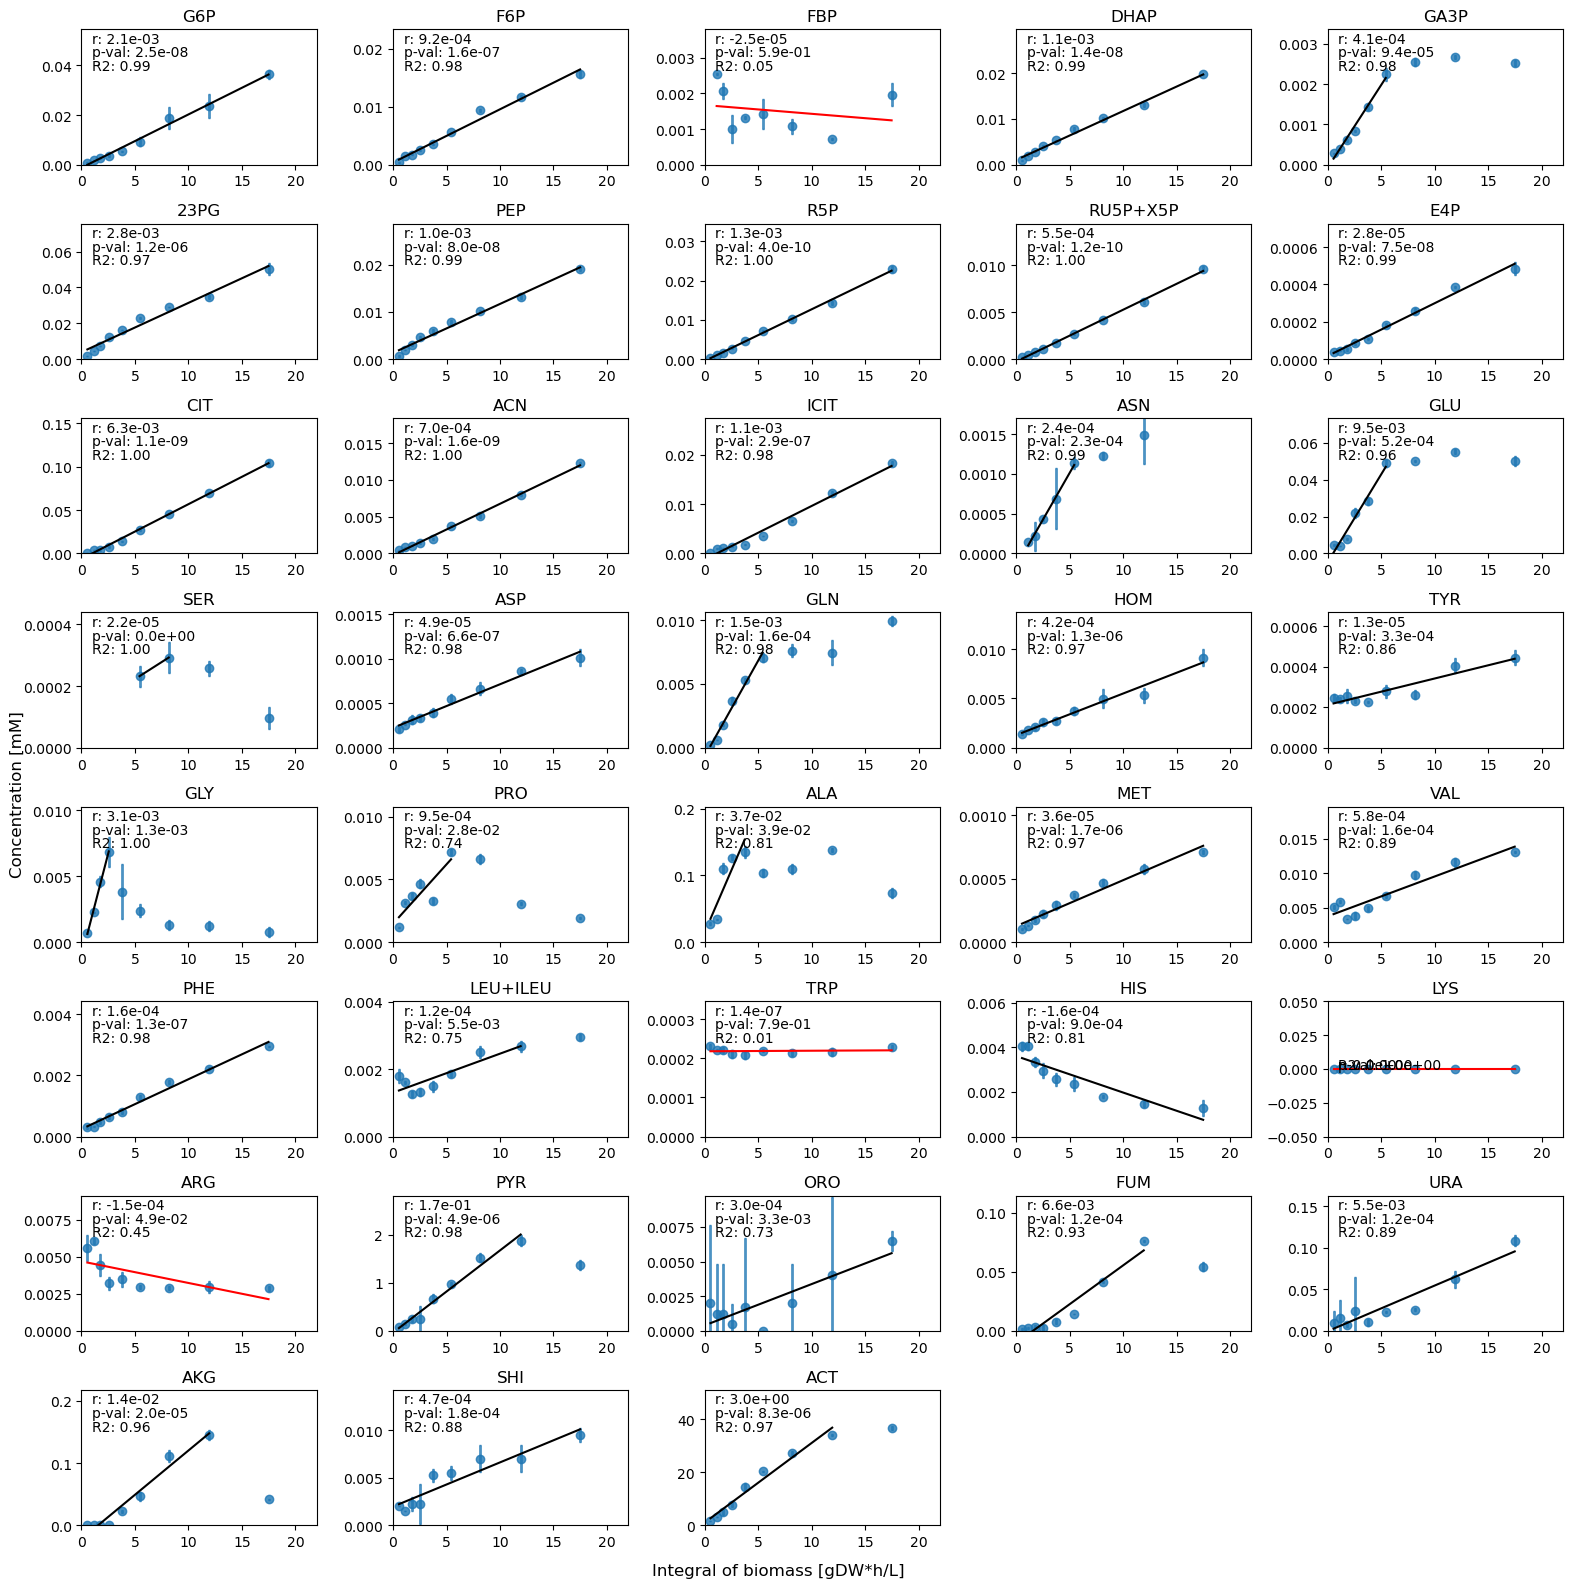

In [56]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
for i,c in enumerate(concentrations.columns):
    # print(c)
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if np.sum(rate_conc == 0) > 1:
        print(c, 'More than 1 zero')
    # conc[conc==0] = np.nan
    res = scipy.stats.linregress(x[idx], conc[idx])
    print(f"R-squared: {res.rvalue**2:.6f}")
    r2 = res.rvalue**2
    
    # fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[idx],
    #                                            conc[idx], full_output=True)
    # rate = fit[0]
    # std_err = np.sqrt(np.diag(cov))[0]
    # t_score = fit[0]/std_err
    # n_df = np.sum(idx)-2
    # p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
    # data = [rate, std_err, t_score, n_df, p_val, c, p_val < 0.05]
    data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
    data_list.append(data)
    # rate_dict_m[c] = fit[0]
    # print(fit)
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    ax = axes[i]
    # ax.scatter(x, conc)
    # ax.scatter(x, conc)
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha = 0.8)
    if r2 > 0.5:
        ax.plot(x_fit, y_fit, 'k')
    else:
        ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )
    ax.set_xlim(0, 22)
    y_max = np.max(conc[idx])*1.5
    ax.set_ylim(0, y_max)
    ax.annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    ax.annotate(f'R2: {r2:.2f}', (1, y_max*0.7))
    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('blicheniformis_fitted_rates_manual_limits.png', dpi = 400)
plt.show()

In [62]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


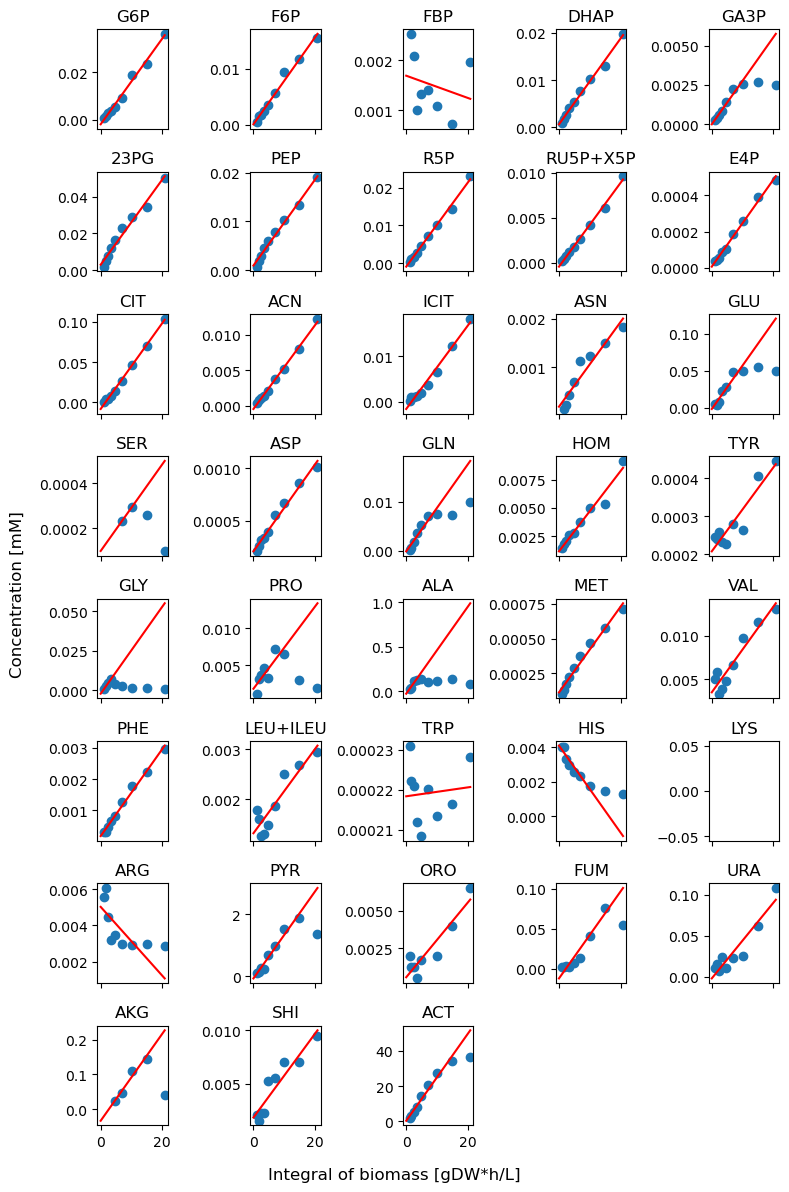

In [128]:
rate_dict = {}
fig, axes = plt.subplots(8,5, figsize = (8, 12), sharex = True)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
max_idx = 9

for i,c in enumerate(concentrations.columns):
    conc = concentrations[c]*1e-3
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index <= max_idx
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
        
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    if (max_idx-1 in rate_conc.index) and (max_idx in rate_conc.index):
        if rate_conc[max_idx] < rate_conc[max_idx-1]:
            selection[max_idx] = False
            if rate_conc[max_idx-1] < rate_conc[max_idx-2]:
                selection[max_idx-1] = False
    # print(c)
    # print(conc[nan_idx&time_idx])
    if c in ['GA3P', 'GLU', 'GLN']:
        selection[max_idx] = False
        selection[max_idx-1] = False
    elif c in ['ACT']:
        selection[max_idx] = False
    elif c in ['GLY', 'ALA']:
        selection[5:] = False
        
    if len(conc[nan_idx&time_idx&selection]) >1:
        fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                                   conc[nan_idx&time_idx&selection],
                                                   full_output=True)
        rate_dict[c] = fit[0]
    else:
        rate_dict[c] = np.nan

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x[nan_idx&time_idx], conc[nan_idx&time_idx])
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c)

i +=1
# print(i)
while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.show()


In [23]:
rate_dict

{'G6P': 0.001815705613309207,
 'F6P': 0.0007798065891321033,
 'FBP': -2.2290233815899512e-05,
 'DHAP': 0.0009053751961758618,
 'GA3P': 0.0002777098353519472,
 '23PG': 0.0023269325323102743,
 'PEP': 0.0008793889391690532,
 'R5P': 0.0011145513920963609,
 'RU5P+X5P': 0.0004673899907093387,
 'E4P': 2.4006959064244546e-05,
 'CIT': 0.005347225038896686,
 'ACN': 0.0005908451959066858,
 'ICIT': 0.0009174293307948615,
 'ASN': 8.696520069241675e-05,
 'GLU': 0.005895708179699767,
 'SER': 1.938880328710837e-05,
 'ASP': 4.152096423713328e-05,
 'GLN': 0.0008890191989950809,
 'HOM': 0.00035491291273643735,
 'TYR': 1.1055345671723247e-05,
 'GLY': 0.002764901793985923,
 'PRO': 0.0005552994250440598,
 'ALA': 0.048921948060388645,
 'MET': 3.0751357864823025e-05,
 'VAL': 0.0004911718670588694,
 'PHE': 0.00013826590547265957,
 'LEU+ILEU': 8.442498026913601e-05,
 'TRP': 1.1168246633786874e-07,
 'HIS': -0.00025191027949105914,
 'LYS': nan,
 'ARG': -0.00019085248736203762,
 'PYR': 0.1407338295394529,
 'ORO': 

# Get model

In [57]:
# Couldn't get this model to work with reframed 
model_fn = '../../models/b_licheniformis/iBsu1147_irr_enz_constraint_adj.xml'
model_ez = cobra.io.read_sbml_model(model_fn)
# model = cobra.io.load_matlab_model('../../models/{0}/ec_iYO844.mat'.format(species))

model_ez.solver = 'gurobi'

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19


In [58]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'{m_id}_c')

# Shadow prices

In [59]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = -5.3
    shadow_prices = leakage.estimate_shadow_prices(model_ez, delta=0.01, metabolites = measured_metabolites)

# Turnover

In [60]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = -5.3
    solution = cobra.flux_analysis.pfba(model)
turnover = {}
for m_id in measured_metabolites:
    m = model_ez.metabolites.get_by_id(m_id)
    turnover[m_id] = m.summary(solution).producing_flux['flux'].sum()

    

# Make spreadsheet

In [67]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The L-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites.get_by_id(m_id)
        Nc = m.elements['C']
        mass = m.formula_weight
        
        data.append([abbr, bigg_id, name, mv, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']
['ru5p__D', 'xu5p__D']
['leu__L', 'ile__L']


In [69]:
# data = []
# for abbr, rate in rate_dict.items():
#     bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
#     rate = rate/len(bigg_ids)
#     for bigg_id in bigg_ids:
#         name =met_abrv_to_name[abbr]
#         m_id = f'{bigg_id}_c'
#         mv = -shadow_prices[m_id]
#         m = model_ez.metabolites.get_by_id(m_id)
#         Nc = m.elements['C']
#         mass = m.formula_weight
        
#         data.append([bigg_id, name, rate, mv, turnover[m_id], Nc, mass])
# df_rate = pd.DataFrame(data, columns = ['BiGG ID', 'Metabolite', 'Rate [mmol/gDW/h]', 
#                                         'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
#                                         'Mol weight [g/mol]'])

In [70]:
df_rate['Species'] = 'B. licheniformis'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [71]:
df_rate.to_csv('paczia_13_rates_blicheniformis_130524.csv')

In [72]:
df_rate

,Metabolite abbrv.,BiGG ID,Metabolite,Metabolite value [gDW/mmol],Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std.Err [mmol/gDW/h],R2,Species,Carbon source,Dataset
0,G6P,g6p_A,Glucose-6-phosphate,0.081017,5.300000,6,259.127841,0.002148,0.000080,0.990387,B. licheniformis,Glucose,Paczia-13
1,F6P,f6p_B,Fructose-6-phosphate,0.081019,5.198244,6,259.127841,0.000920,0.000045,0.983753,B. licheniformis,Glucose,Paczia-13
2,DHAP,dhap,Dihydroxyacetonephosphate,0.043233,31.144652,3,169.049901,0.001071,0.000036,0.991950,B. licheniformis,Glucose,Paczia-13
3,GA3P,g3p,Glyceraldehyde-3-phosphate,0.043234,9.572017,3,169.049901,0.000411,0.000026,0.984203,B. licheniformis,Glucose,Paczia-13
4,23PG,2pg,2/3-phosphoglycerate,0.034358,8.110633,3,184.041361,0.001376,0.000126,0.971400,B. licheniformis,Glucose,Paczia-13
5,23PG,3pg,2/3-phosphoglycerate,0.034358,9.380943,3,184.041361,0.001376,0.000126,0.971400,B. licheniformis,Glucose,Paczia-13
6,PEP,pep,Phosphoenolpyruvate,0.034411,8.110633,3,166.026081,0.001040,0.000046,0.986661,B. licheniformis,Glucose,Paczia-13
7,R5P,r5p,Ribose-5-phosphate,0.068426,0.198572,5,229.101861,0.001319,0.000027,0.997069,B. licheniformis,Glucose,Paczia-13
8,RU5P+X5P,ru5p__D,Ribu-/Xylulose-5-phosphate,0.068426,0.173809,5,229.101861,0.000277,0.000007,0.997940,B. licheniformis,Glucose,Paczia-13
9,RU5P+X5P,xu5p__D,Ribu-/Xylulose-5-phosphate,0.068425,0.173809,5,229.101861,0.000277,0.000007,0.997940,B. licheniformis,Glucose,Paczia-13
